# Tutorial 4


-----------------------------------------------------------------------------------


# Exact diagonalization (ED) of Fermi-Hubbard model:

-----------------------------------------------------------------------------------

**Fermi-Hubbard Model**:


Hamiltonian is:
\begin{equation}
\mathcal{H} = t\sum\limits_{\langle ij \rangle,\sigma}c^\dagger_{i\sigma}c_{j\sigma} + U\sum\limits_{i }(n^\uparrow_{i}-1/2)(n^\downarrow_{i}-1/2)
\end{equation}
where, $t$ is the hopping term, while $U$ is the on-site Hubbard (density-density) interaction term. And $c^\dagger_{i\sigma}, c_{i\sigma}$ are the fermionic creation and annihilation operators for spin '$\sigma$' (+1/2 or -1/2).
        

-----------------------------------------------------------------------------------
**Hamiltonian Matrix:**
 
   * Practical Implementation: 
        * **Diagonal matrix elements**: Since the basis is the number operator basis, so the density-density interaction term or the Hubbard term  is diagonal in a sector of Fock basis. e.g: a diagonal matrix element can be calculated as,
       
        $$H_{i,i} =
        \langle \{0,0,1,...\},\{0,1,0,0...\} | \mathcal{H}_d | \{0,0,1,...\},\{0,1,0,0,...\} \rangle$$
        $$\langle \{0,0,1,...\},\{0,1,0,0...\} | U (n^\uparrow_{1}-1/2)(n^\downarrow_{1}-1/2) | \{0,0,1,...\},\{0,1,0,0,...\} \rangle  \nonumber \\
        = - U/4 $$
        and so on. This is very similar to what has been done in earlier diagonalization notes.
        
        * **Off-diagonal matrix elements**: The hopping term (t) is off-diagonal within the sector since the hopping changes the sequence of numbers within the lists '$n_{\uparrow,\downarrow}$' leading to a different basis vector. 
        Also, we know that this is **tricky** because of the moves of the spins on the lattice that has to be antisymmetrized. Below is the idea to calculate off-diagonal matrix elements for spin-ups ($n^{\uparrow}$ list), you can then implement in a similar fashion for spin-downs. 
        
        Consider the following:
        $c^\dagger_{0,\uparrow}c_{1,\uparrow}|\{0,1,1,0,...\},\{1,0,1,0,...\}\rangle$ 
        
        For convenience we shall ignore the other spins list (and drop of the indices of spins) as the hopping is always between two same spins states.
        
        For fermions in the bulk: $c^\dagger_0c_1|\{0,1,1,0\}\rangle$ = $(c^\dagger_0c_1)c^\dagger_1c^\dagger_2|\{0,0,0,0\}\rangle$ = $c^\dagger_0(1-c^\dagger_1c_1)c^\dagger_2|\{0,0,0,0\}\rangle$ = $c^\dagger_0c^\dagger_2|\{0,0,0,0\}\rangle$ = $|\{1,0,1,0\}\rangle$
        
        For fermions at the chain boundary: $c^\dagger_3c_0|\{1,0,1,0\}\rangle = (c^\dagger_3c_0)c^\dagger_0c^\dagger_2|\{0,0,0,0\}\rangle=c^\dagger_3(1-c^\dagger_0c_0)c^\dagger_2|\{0,0,0,0\}\rangle$ =  $c^\dagger_3c^\dagger_2|\{0,0,0,0\}\rangle$ = $-c^\dagger_2c^\dagger_3|\{0,0,0,0\}\rangle$ =  $-|\{0,0,1,1\}\rangle$
        
        **Notice the change of sign when the hopping is at the boundary. Make sure you understand in which femion gauge choice the above has been done.**

        Hint: For nearest neighbor hoppings and for a chain lattice, the only problem of sign of calculating the off-diagonal matrix elements arise at the boundary. So, you can specially take care of this sign on the bond at the boundary in this case. 
   
-----------------------------------------------------------------------------------   

- Name: Siddhant Midha
- Roll no.: 200070078
- *Declaration*. I have adhered to the academic code of conduct and will do so in the future as well.



In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from qutip import *
from scipy.sparse import csr_matrix
from numpy import sqrt, pi 
plt.rcParams.update({'font.size': 25 })
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



#  Solve the Fermi-Hubbard Hamiltonian using ED.
## Problem 1:
    1. Print the value of ground state energy for a system size of N=4,6
       in a full Hilbert space.
    2. Do the same within a fixed sector of particle conserving basis which the ground state
       of the system falls into which you have to identify.
    3. Try to plot the Energy levels (or spectrum) in a single plot. Just like 'bands'.


In [13]:
#helper functions 

# full space dictionary (strings)
def create_statedict_total(L):
    D = int(2 ** L)  
    states_dict = {}
    ctr = 0
    for i in range(D):
        for j in range(D):
            up = (bin(i)[2:])
            down = (bin(j)[2:])
            up = '0'*(L-len(up)) + up 
            down = '0'*(L-len(down)) + down 
            states_dict[ctr] = [up,down] 
            ctr += 1
    return states_dict

# spinless space dictionary (strings)
def create_statedict_single(L):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    states_dict = {}
    for i in range((D)):
        state = bin(i)[2:]
        state = '0'*(L-len(state)) + state 
        states_dict[i] = state 
    return states_dict

# binary search for spinless space
def find_ind_single(state,lookup):
    #state is in binary
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(lookup[mid],2) < int(state,2):
            low = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) > int(state,2):
            high = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) == int(state,2):
            return mid 

#binary search for full space
def find_ind_full(state,lookup):
    #state is a tuple of binaries
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(''.join(lookup[mid]),2) < int(''.join(state),2):
            low = mid
            mid = int((low+high)/2)
        elif int(''.join(lookup[mid]),2) > int(''.join(state),2):
            high = mid
            mid = int((low+high)/2)
        elif int(''.join(lookup[mid]),2) == int(''.join(state),2):
            return mid 

#flip a state at specified sites
def flipbits_single(state,i,j):
    copystate = state 
    copystate = list(copystate)
    bit_i = state[i]
    bit_j = state[j]
    if bit_i == '0':
        copystate[i] = '1'
    else:
        copystate[i] = '0'
    if bit_j == '0':
        copystate[j] = '1'
    else:
        copystate[j] = '0'
    copystate = ''.join(copystate)
    return copystate

# count number of excitations between two sites
def count_excitations(state,site1,site2):
    ctr = 0
    for site in range(site1+1,site2):
        ctr += state[site]
    return ctr

# spinless hamiltonian
def singlespin_hamil(L,t):
    D = 2 ** L
    H_spin = np.zeros((D, D))
    state_dict = create_statedict_single(L)
    for site in range(L):
        nbr_site = (site + 1) % L
        for index in range(D):
            state = state_dict[index]
            nbr_index = find_ind_single(flipbits_single(state,site,nbr_site),state_dict)
            sign = (-1) ** (count_excitations(state,site,nbr_site))
            if state[site] == '0' and state[nbr_site] == '1':
                H_spin[index, nbr_index] += t * sign
            if state[site] == '1' and state[nbr_site] == '0':
                H_spin[index, nbr_index] += t * sign
    return H_spin

# helper fn: returns G.S. e-val
def return_gseval(mat):
    v, vv = np.linalg.eigh(mat)
    sorted_indices = np.argsort(v)
    sorted_eigenvalues = v[sorted_indices]
    return sorted_eigenvalues[0]

# full hamiltonian USING spinless module
def full_FH_hamil(L,t,U): 
    D = (4**L)
    H_full = np.zeros((D,D))
    state_dict = create_statedict_total(L)
    H_spin = singlespin_hamil(L,t)
    H_full = np.kron(np.eye(2 ** L),H_spin) + np.kron(H_spin,np.eye(2 ** L))
    for index in range(D):
        state = state_dict[index]
        ups = list(state[0]) 
        ups = [int(x) for x in ups]
        downs = list(state[1])
        downs = [int(x) for x in downs]
        ups = np.array(ups) - 0.5
        downs = np.array(downs) - 0.5
        mul = ups * downs
        H_full[index, index] = np.sum(mul) * U
    return H_full

# full hamiltonian from scratch
def full_FH_hamil_direct(L,t,U):
    D = (4**L)
    H_full = np.zeros((D,D))
    state_dict = create_statedict_total(L)
    for site in range(L):
        nbr_site = (site + 1) % L
        for index in range(D):
            state = state_dict[index]
            state_up = state[0]
            state_down = state[1]

            # for up
            flipped = flipbits_single(state_up,site,nbr_site)
            flipped_state = [flipped,state_down]
            nbr_index = find_ind_full(flipped_state,state_dict)
            sign = (-1) ** (count_excitations(state_up,site,nbr_site))
            if state_up[site] == '0' and state_up[nbr_site] == '1':
                H_full[index, nbr_index] += t * sign
            if state_up[site] == '1' and state_up[nbr_site] == '0':
                H_full[index, nbr_index] += t * sign

            # for down
            flipped = flipbits_single(state_down,site,nbr_site)
            flipped_state = [state_up,flipped]
            nbr_index = find_ind_full(flipped_state,state_dict)
            sign = (-1) ** (count_excitations(state_down,site,nbr_site))
            if state_down[site] == '0' and state_down[nbr_site] == '1':
                H_full[index, nbr_index] += t * sign
            if state_down[site] == '1' and state_down[nbr_site] == '0':
                H_full[index, nbr_index] += t * sign

            ups = list(state_up) 
            ups = [int(x) for x in ups]
            downs = list(state_down)
            downs = [int(x) for x in downs]
            ups = np.array(ups) - 0.5
            downs = np.array(downs) - 0.5
            mul = ups * downs
            H_full[index, index] = np.sum(mul) * U
    return H_full




In [14]:
# check equivalence

np.all(full_FH_hamil(L,t,U) == full_FH_hamil_direct(L,t,U))

True

print ground state energies

In [15]:
L = 4
t = 1 
U = 1
state_dict = create_statedict_total(L)
h = (full_FH_hamil(L,t,U))

return_gseval(h)

-5.723265519527187

In [16]:
L = 6
t = 1 
U = 1
state_dict = create_statedict_total(L)
h = (full_FH_hamil(L,t,U))

return_gseval(h)

-8.101158293375118

now, fix particle number

In [122]:
def sum_str_single(str):
    s = np.sum([int(bit) for bit in list(str)])
    return s

def create_statedict_fixedparticle(L,N=1):
    D = int(2 ** L)  
    states_dict = {}
    ctr = 0
    for i in range(D):
        for j in range(D):
            up = (bin(i)[2:])
            down = (bin(j)[2:])
            up = '0'*(L-len(up)) + up 
            down = '0'*(L-len(down)) + down 
            if(sum_str_single(up) + sum_str_single(down) == N): # fix particle number
                states_dict[ctr] = [up,down] 
                ctr += 1
    return states_dict

# only doing for from scratch approach as it is easier to fix particle number in the whole space
def full_FH_hamil_direct_fixedparticle(L,t,U,N):
    
    state_dict = create_statedict_fixedparticle(L,N)
    D = len(state_dict)
    H_full = np.zeros((D,D))
    for site in range(L-1):
        nbr_site = (site + 1) % L
        for index in range(D):
            state = state_dict[index]
            state_up = state[0]
            state_down = state[1]

            # for up
            flipped = flipbits_single(state_up,site,nbr_site)
            flipped_state = [flipped,state_down]
            
            sign = (-1) ** (count_excitations(state_up,site,nbr_site))
            if state_up[site] == '0' and state_up[nbr_site] == '1':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += t * sign
            if state_up[site] == '1' and state_up[nbr_site] == '0':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += t * sign

            # for down
            flipped = flipbits_single(state_down,site,nbr_site)
            flipped_state = [state_up,flipped]
            sign = (-1) ** (count_excitations(state_down,site,nbr_site))
            if state_down[site] == '0' and state_down[nbr_site] == '1':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += t * sign
            if state_down[site] == '1' and state_down[nbr_site] == '0':
                nbr_index = find_ind_full(flipped_state,state_dict)
                H_full[index, nbr_index] += t * sign

            ups = list(state_up) 
            ups = [int(x) for x in ups]
            downs = list(state_down)
            downs = [int(x) for x in downs]
            ups = np.array(ups) - 0.5
            downs = np.array(downs) - 0.5
            mul = ups * downs
            H_full[index, index] = np.sum(mul) * U
    return H_full

now, GS energies

In [133]:
L = 4
t = 1 
U = 1

return_gseval(full_FH_hamil_direct_fixedparticle(L,t,U,N=4)) #half-filling GS energy matches!

-4.575365620447477

In [134]:
L = 6
t = 1 
U = 1

return_gseval(full_FH_hamil_direct_fixedparticle(L,t,U,N=6))

-7.128893198968257

now, spectrum

Text(0, 0.5, 'spectrum')

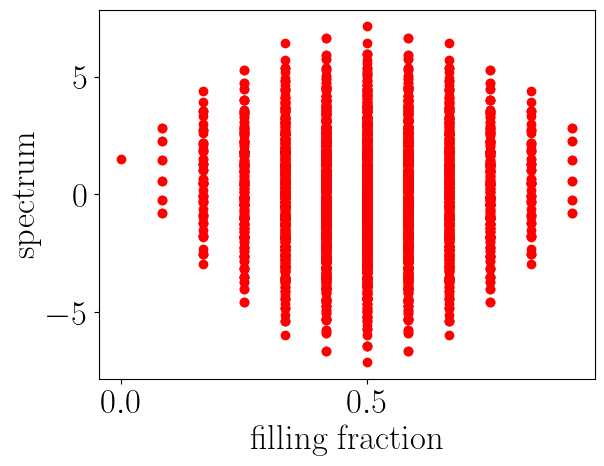

In [136]:
for N in range(2*L):
    v, _ = np.linalg.eig(full_FH_hamil_direct_fixedparticle(L,t,U,N=N))
    v = np.sort(v)
    for ww in v:
        plt.scatter(x = N/(2*L), y = ww, color='red')


plt.xlabel('filling fraction')
plt.ylabel('spectrum')
